# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
df.shape

(45993, 3)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null float64
title         45993 non-null object
email         45976 non-null object
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [5]:
df.groupby('email').agg('count').iloc[:,0].sort_values(ascending=False)

email
2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
f8c978bcf2ae2fb8885814a9b85ffef2f54c3c76    158
284d0c17905de71e209b376e3309c0b08134f7e2    148
d9032ff68d0fd45dfd18c0c5f7324619bb55362c    147
18e7255ee311d4bd78f5993a9f09538e459e3fcc    147
c60bb0a50c324dad0bffd8809d121246baef372b    145
276d9d8ca0bf52c780b5a3fc554fa69e74f934a3    145
56832a697cb6dbce14700fca18cffcced367057f    144
b2d2c70ed5de62cf8a1d4ded7dd141cfbbdd0388    142
ceef2a24a2a82031246814b73e029edba51e8ea9    140
8dc8d7ec2356b1b106eb3d723f3c234e03ab3f1e    137
e38f123afecb40272ba4c47cb25c96a9533006fa    136
53db7ac77dbb80d6f5c32ed5d19c1a8720078814    132
6c14453c049b1ef4737b08d56c480419794f91c2    131
fd824fc62b4753107e3db7704cd9e8a4a1c961f1    116
c45f9495a76bf95d2633444817f1be8205ad542d    114
12bb8a9740400ced27ae5a7d4c990ac3b7

In [6]:
# Fill in the median and maximum number of user_article interactios below

median_val = df.groupby('email').agg('count').iloc[:,0].median()# 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user =df.groupby('email').agg('count').max()[0] # The maximum number of user-article interactions by any 1 user is ______.

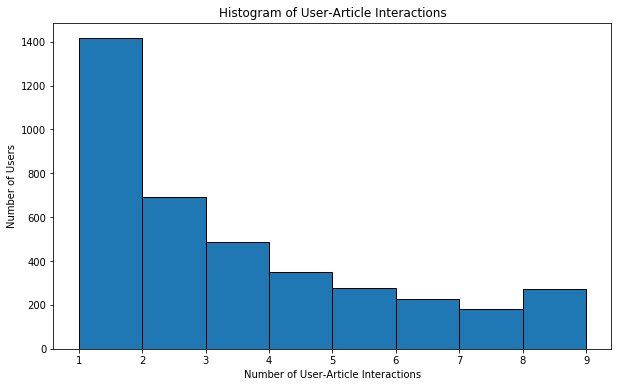

In [7]:
# Group by 'email' and count the number of interactions
user_interactions = df.groupby('email').agg('count')

# Increase the plot size
plt.figure(figsize=(10, 6))

# Create a histogram
plt.hist(user_interactions['article_id'], bins=range(1, int(user_interactions['article_id'].mean()) + 2), edgecolor='black')

# Set labels and title
plt.xlabel('Number of User-Article Interactions')
plt.ylabel('Number of Users')
plt.title('Histogram of User-Article Interactions')

# Show the plot
plt.show()

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [8]:
# Find and explore duplicate articles

In [9]:
# 1. Explore Duplicate Articles
duplicate_articles = df_content[df_content.duplicated(subset='article_id', keep=False)]
duplicate_articles.shape

(10, 5)

In [10]:
# Remove any rows that have the same article_id - only keep the first
# 2. Remove Duplicate Articles
df_content = df_content.drop_duplicates(subset='article_id', keep='first')

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [11]:
unique_articles =df['article_id'].nunique()# The number of unique articles that have at least one interaction
total_articles = df_content['article_id'].nunique()# The number of unique articles on the IBM platform
unique_users = df['email'].nunique()# The number of unique users
user_article_interactions = df.shape[0]# The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [12]:
most_viewed_article_id = str(df.article_id.value_counts().index[0])# The most viewed article in the dataset as a string with one value following the decimal 
max_views = df.article_id.value_counts().head(1).values[0]# The most viewed article in the dataset was viewed how many times?

In [13]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [14]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [15]:
df[df['article_id'].isin(df['article_id'].value_counts().head(10).index)]

,article_id,title,user_id
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
6,1429.0,use deep learning for image classification,7
8,1314.0,healthcare python streaming application demo,9
13,1314.0,healthcare python streaming application demo,4
14,1170.0,"apache spark lab, part 1: basic concepts",10
20,1314.0,healthcare python streaming application demo,18
29,1364.0,predicting churn with the spss random tree alg...,24
31,1162.0,analyze energy consumption in buildings,25
37,1431.0,visualize car data with brunel,28


In [16]:
df['article_id'].value_counts().head(10)

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
1314.0    614
1293.0    572
1170.0    565
1162.0    512
1304.0    483
Name: article_id, dtype: int64

In [17]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Count the occurrences of each article_id
    article_counts = df['article_id'].value_counts()

    # Get the top n article_ids
    top_article_ids = article_counts.head(n).index

    # Get the corresponding article titles
    top_articles = df[df['article_id'].isin(top_article_ids)]['title'].unique().tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Count the occurrences of each article_id
    article_counts = df['article_id'].value_counts()

    # Get the top n article_ids
    top_article_ids = article_counts.head(n).index

    return top_article_ids.astype(str).tolist()

In [18]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [19]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [20]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Create a binary matrix where interactions are represented by 1 and missing values by 0
    user_item = df.pivot_table(index='user_id', columns='article_id', aggfunc=lambda x: 1 if len(x) > 0 else 0, fill_value=0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [21]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [22]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns a list of users ordered by similarity
    
    '''
    # Compute similarity of each user to the provided user
    similarity = user_item.loc[user_id].dot(user_item.T)

    # Sort by similarity in descending order
    similarity = similarity.sort_values(ascending=False)

    # Create a list of just the user ids
    most_similar_users = similarity.index.tolist()

    # Remove the own user's id
    most_similar_users.remove(user_id)

    return most_similar_users

In [23]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [24]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Filter the DataFrame to get rows with the specified article_ids
    articles = df[df['article_id'].isin(article_ids)]

    # Get the unique article names
    article_names = articles['title'].unique().tolist()

    return article_names


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    # Get the row corresponding to the user_id
    user_row = user_item.loc[user_id]

    # Extract the article_ids where the user has interacted (value is 1)
    article_ids = user_row[user_row == 1].index.get_level_values(1).astype(str).tolist()
    article_names = df[df['article_id'].isin(article_ids)]['title'].tolist()

    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Get the articles seen by the user
    seen_article_ids, _ = get_user_articles(user_id, user_item)

    # Initialize the recommendations list
    recs = []

    # Find similar users for the given user_id
    similar_users = find_similar_users(user_id, user_item)

    # Loop through similar users and recommend articles the user hasn't seen
    for user in similar_users:
        # Get the articles seen by the similar user
        sim_user_articles, _ = get_user_articles(user, user_item)

        # Filter out articles the given user has already seen
        new_recs = np.setdiff1d(sim_user_articles, seen_article_ids, assume_unique=True)

        # Add new recommendations to the list
        recs.extend(new_recs)

        # Check if we have enough recommendations
        if len(recs) >= m:
            break

    # Trim the list to the desired number of recommendations
    recs = recs[:m]

    return recs
 

In [25]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'timeseries data analysis of iot events by using jupyter notebook',
 'graph-based machine learning',
 'using brunel in ipython/jupyter notebooks',
 'experience iot with coursera',
 'the 3 kinds of context: machine learning and the art of the frame',
 'deep forest: towards an alternative to deep neural networks',
 'this week in data science (april 18, 2017)',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty']

In [26]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [27]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by the number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Ensure the index of user_item is of integer type
    user_item.index = user_item.index.astype(int)

    # Create a DataFrame with neighbor_id, similarity, and num_interactions columns
    neighbors_df = pd.DataFrame({
        'neighbor_id': user_item.index,  # set neighbor_id column equal to user_item index
        'similarity': user_item.loc[user_id].dot(user_item.T),  # calculate similarity using dot product
        'num_interactions': df.groupby('user_id').count()['article_id']
    })

    # Sort the DataFrame by similarity and then by number of interactions
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)

    # Reset the index
    neighbors_df = neighbors_df.reset_index(drop=True)

    # Drop the row with the user_id as itself will be most similar
    neighbors_df = neighbors_df[neighbors_df.neighbor_id != user_id]

    return neighbors_df


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    recs = set()  # recommendations to be made (using set for constant-time membership testing)
    
    user_articles_ids_seen, _ = get_user_articles(user_id, user_item)  # article ids seen by our user
    closest_neighs = get_top_sorted_users(user_id, df, user_item).neighbor_id.tolist()  # neighbour user ids closest to our user

    for neigh_id in closest_neighs:
        neigh_articles_ids_seen, _ = get_user_articles(neigh_id, user_item)  # articles seen by others like our user
        new_recs = set(neigh_articles_ids_seen) - set(user_articles_ids_seen)  # find those not seen by user
        recs.update(new_recs)  # update the set of recommendations

        if len(recs) >= m:
            break

    recs = list(recs)[:m]  # convert to a list and limit to m recommendations
    rec_names = get_article_names(recs, df=df)

    return recs, rec_names

In [28]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['730.0', '1356.0', '1329.0', '1426.0', '1324.0', '1163.0', '302.0', '205.0', '1153.0', '1085.0']

The top 10 recommendations for user 20 are the following article names:
['ibm watson facebook posts for 2015', 'analyze open data sets with spark & pixiedust', 'developing for the ibm streaming analytics service', 'accelerate your workflow with dsx', "a beginner's guide to variational methods", 'occupation (2015): united states demographic measures', 'use spark for scala to load data and run sql queries', 'airbnb data for analytics: vienna calendar', 'airbnb data for analytics: chicago listings', 'ingest data from message hub in a streams flow']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [29]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0].neighbor_id # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9].neighbor_id# Find the 10th most similar user to user 131

In [30]:
user1_most_sim

3933

In [31]:
user131_10th_sim

242

In [32]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

When dealing with a new user without any prior interactions, a practical approach is to rely on Rank-Based Recommendations using the `get_top_articles` function. This involves recommending the most popular articles since we lack information about the user's preferences or interactions with other users. As we gather more data about the user, we can gradually transition to a more nuanced recommendation strategy, incorporating a blend of Rank-Based, Content-Based, and Collaborative Filtering techniques to provide more personalized and relevant suggestions. This evolution allows for a more comprehensive and tailored recommendation system as we learn more about the user's preferences and behaviors over time.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [33]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10, df)# Your recommendations here



In [34]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [35]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [36]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
user_item_matrix.isnull().sum().sum()

0

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [38]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

In [39]:
u.shape,s.shape,vt.shape

((5149, 5149), (714,), (714, 714))

there are no missing values, thats why we can use SVD instead of FunkSVD 😀

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

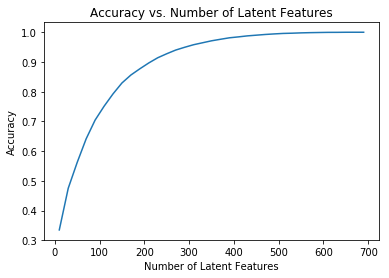

In [40]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [41]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [51]:
len(user_item_train)

4487

In [53]:
len(user_item_test)

682

In [49]:
train_idx = user_item_train.index 
train_idx 

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            4478, 4479, 4480, 4481, 4482, 4483, 4484, 4485, 4486, 4487],
           dtype='int64', name='user_id', length=4487)

In [60]:
train_arts = user_item_train.columns #714 movies in train set
train_arts

MultiIndex(levels=[['title'], [0.0, 2.0, 4.0, 8.0, 9.0, 12.0, 14.0, 15.0, 16.0, 18.0, 20.0, 25.0, 26.0, 28.0, 29.0, 30.0, 32.0, 33.0, 34.0, 36.0, 39.0, 40.0, 43.0, 48.0, 50.0, 51.0, 53.0, 54.0, 57.0, 58.0, 59.0, 60.0, 62.0, 64.0, 65.0, 68.0, 74.0, 76.0, 77.0, 78.0, 80.0, 81.0, 82.0, 87.0, 89.0, 92.0, 96.0, 98.0, 100.0, 101.0, 102.0, 103.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 115.0, 116.0, 117.0, 120.0, 122.0, 124.0, 125.0, 130.0, 131.0, 132.0, 134.0, 136.0, 138.0, 142.0, 143.0, 145.0, 146.0, 151.0, 152.0, 153.0, 157.0, 158.0, 162.0, 164.0, 173.0, 176.0, 181.0, 183.0, 184.0, 188.0, 189.0, 191.0, 193.0, 194.0, 195.0, 202.0, 205.0, 210.0, 213.0, 215.0, 221.0, 223.0, 224.0, 225.0, 230.0, 232.0, 233.0, 234.0, 236.0, 237.0, 239.0, 240.0, 241.0, 244.0, 250.0, 251.0, 252.0, 253.0, 254.0, 256.0, 258.0, 260.0, 263.0, 266.0, 268.0, 270.0, 273.0, 277.0, 278.0, 283.0, 284.0, 288.0, 291.0, 295.0, 297.0, 298.0, 299.0, 302.0, 303.0, 310.0, 311.0, 313.0, 314.0, 315.0, 316.0, 319.0, 323.0, 

In [54]:
test_idx

Int64Index([2917, 3024, 3093, 3193, 3527, 3532, 3684, 3740, 3777, 3801,
            ...
            5140, 5141, 5142, 5143, 5144, 5145, 5146, 5147, 5148, 5149],
           dtype='int64', name='user_id', length=682)

In [56]:
len(test_arts)

574

In [58]:
len(test_idx.difference(train_idx))

662

In [61]:
len(test_arts.difference(train_arts))

0

In [63]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [64]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [65]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
s_train.shape, u_train.shape, vt_train.shape

((714,), (4487, 4487), (714, 714))

In [69]:
num_latent_feats = np.arange(10, 700 + 10, 20)
sum_errs_train = []
sum_errs_test = []

# Find rows that are present both in training and test set (= users we can make predictions for)
user_ids_can_predict = np.intersect1d(user_item_train.index, user_item_test.index)

# Find the indices of these users in user_item_train and derive u_test by reducing u_train to these indices
row_idxs = user_item_train.index.isin(user_ids_can_predict)
u_test = u_train[row_idxs, :]

# Also reduce user_item_test to those indices
user_item_test_subset = user_item_test.loc[user_ids_can_predict]

# Find the columns present both in training and test set
col_idxs = user_item_train.columns.isin(user_item_test.columns)
vt_test = vt_train[:, col_idxs]

for k in num_latent_feats:
    # Restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    # Take dot product
    user_item_train_pred = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_pred = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # Compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_pred)
    diffs_test = np.subtract(user_item_test_subset, user_item_test_pred)
    
    # Total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)


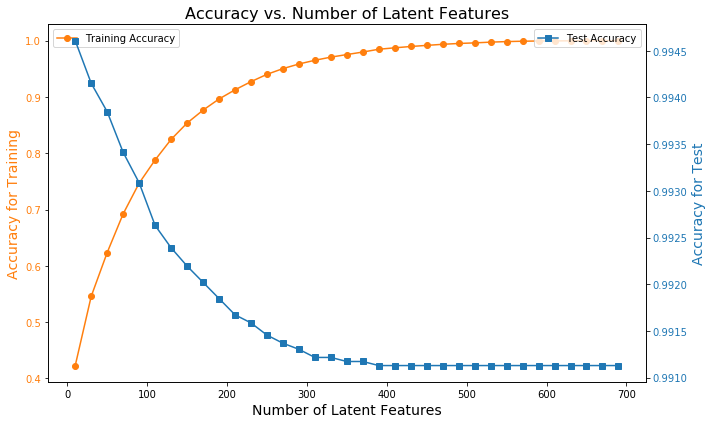

In [70]:
# Plotting the training and test accuracies
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:orange'
ax1.set_xlabel('Number of Latent Features', fontsize=14)
ax1.set_ylabel('Accuracy for Training', color=color, fontsize=14)
ax1.plot(num_latent_feats, 1 - np.array(sum_errs_train) / df.shape[0], color=color, marker='o', label='Training Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Accuracy vs. Number of Latent Features', fontsize=16)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Accuracy for Test', color=color, fontsize=14)  # we already handled the x-label with ax1
ax2.plot(num_latent_feats, 1 - np.array(sum_errs_test) / df.shape[0], color=color, marker='s', label='Test Accuracy')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

fig.tight_layout()  # otherwise, the right y-label is slightly clipped
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

From the analysis above, it is evident that the training data's accuracy improves as the number of latent features increases. However, a contrasting trend is observed in the accuracy of the test data, indicating a potential issue with overfitting as latent features increase. Hence, it is advisable to maintain a relatively low number of latent features to mitigate this effect. 

Moreover, increasing the latent featres decrease the accuracy of the test dataset but not for the training set. Its worth to note that this dataset is for 20 users hence the high accuracy for the test

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])